<a href="https://colab.research.google.com/github/mangohehe/DeepGate2/blob/data-learning/notebooks/Synthesized_Bench_Files_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bench File Generator


## 🍬 Reference: EDA Conda Packages & Notebooks

The [conda-eda](https://github.com/hdl/conda-eda) project maintains a collection of conda packages recipes. Those package can be used to easily bootstrap EDA environments in Jupyter and Colab notebooks.

This notebook leaveraging Conda Packages to generate bench files for sample circuits.

### Install packages

Install packages from the `LiteX-Hub` [channel](https://anaconda.org/LiteX-Hub/repo); also install older packages from the `SymbiFlow` channel, to get better compat with colab: see [conda-eda#146](https://github.com/hdl/conda-eda/issues/146).

In [2]:
!curl -O https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
!bash Miniconda3-py37_4.10.3-Linux-x86_64.sh -b -f -p miniconda-eda/
# iverilog is a Verilog simulation and synthesis tool. Here installs the iverilog package from the LiteX-Hub channel
!miniconda-eda/bin/conda install --yes -c LiteX-Hub iverilog

# verible is a Verilog HDL analysis and transformation tool. Here installs the verible package from the SymbiFlow channel
!miniconda-eda/bin/conda install --yes -c SymbiFlow verible

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 84.9M  100 84.9M    0     0  41.8M      0  0:00:02  0:00:02 --:--:-- 41.8M
PREFIX=/content/miniconda-eda
Unpacking payload ...
Solving environment: / - \ | done

## Package Plan ##

  environment location: /content/miniconda-eda

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py37h27cfd23_1003
    - ca-certificates==2021.7.5=h06a4308_1
    - certifi==2021.5.30=py37h06a4308_0
    - cffi==1.14.6=py37h400218f_0
    - chardet==4.0.0=py37h06a4308_1003
    - conda-package-handling==1.7.3=py37h27cfd23_1
    - conda==4.10.3=py37h06a4308_0
    - cryptography==3.4.7=py37hd23ed53_0
    - idna==2.10=pyhd3eb1b0_0
    - ld_impl_linux-64==2.35.1=h7274673_9
    - libffi==3.3=he6710b0_2
    - libgcc-ng==9.3.0=h5101ec6_17
    - libgomp==9.3.0=h5101ec6_17
    - libstdcxx-ng==9.

### Lint and simulate Verilog cells

Use the `%%bash` magic to lint the content of the cell with [Verible](https://github.com/chipsalliance/verible) and simulate the test bench using [Icarus Verilog](http://iverilog.icarus.com/).


In [17]:
%%bash

# Activate conda environment
source miniconda-eda/bin/activate

# Create Verilog file
cat > counter.v << 'EOF'
module counter(input clk, input rst, output reg[3:0] out);
  always @ (posedge clk) begin
    if (rst)
      out <= 0;
    else
      out <= out + 1;
  end
endmodule

module counter_tb;
  reg clk;
  reg rst;

  wire [3:0] out;

  counter c1(.clk(clk), .rst(rst), .out(out));

  always #1 clk = !clk;

  initial begin
    $dumpfile("test.vcd");
    $dumpvars(0,counter_tb);
    clk <= 0;
    rst <= 1;
    #1  rst <= 0;
    #11 rst <= 1;
    #1  rst <= 0;
    #51 $finish;
  end
endmodule
EOF

# Lint Verilog file
verible-verilog-lint counter.v
if [ $? -ne 0 ]; then
  echo "Linting failed"
  exit 1
fi

# Compile Verilog file
iverilog -o a.out counter.v
if [ $? -ne 0 ]; then
  echo "Compilation failed"
  exit 1
fi

# Run the simulation
vvp a.out
if [ $? -ne 0 ]; then
  echo "Simulation failed"
  exit 1
fi

echo "Simulation completed successfully"


VCD info: dumpfile test.vcd opened for output.
counter.v:28: $finish called at 64 (1s)
Simulation completed successfully


### Plot VCD waveforms

Use [vcdvcd](https://pypi.org/project/vcdvcd/) VCD parser to plot the simulated waveform using regular matplotlib functions.

In [4]:
!python -m pip install vcdvcd

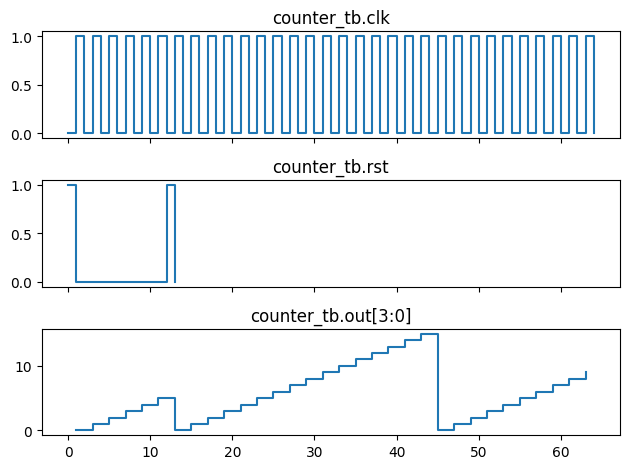

In [15]:
from vcdvcd import VCDVCD

vcd = VCDVCD('test.vcd')
import matplotlib.pyplot as plt
signals = ['counter_tb.clk', 'counter_tb.rst', 'counter_tb.out[3:0]']
f, plots = plt.subplots(len(signals), 1, sharex=True)
for s, plt in zip(signals, plots):
  x, y = zip(*vcd[s].tv)
  y = [int(n, 2) if n != 'x' else None for n in y]
  plt.step(x, y, label=s, where = 'post')
  plt.set_title(s)
f.tight_layout()
f.show()

## 🍡 Treat #2: Yosys synthesis and circuit drawing

[Yosys](https://yosyshq.net/yosys/) is a versatile tool to synthesize HDL designs to netlist and map them to the underlying technology target.

This notebook shows how to synthesize a simple 1-bit adder Verilog design to different levels of technology abstraction (standard logic gates, CMOS, LUTs, discrete ICs) and draw the underlying circuit diagrams.

### Install packages

Install packages from the `LiteX-Hub` and `SymbiFlow` channel.

In [6]:
!curl -O https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
!bash Miniconda3-py37_4.10.3-Linux-x86_64.sh -b -f -p miniconda-synth/
!miniconda-synth/bin/conda install --yes -c LiteX-Hub yosys
!miniconda-synth/bin/conda install --yes -c SymbiFlow verible

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 84.9M  100 84.9M    0     0  30.8M      0  0:00:02  0:00:02 --:--:-- 30.8M
PREFIX=/content/miniconda-synth
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /content/miniconda-synth

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py37h27cfd23_1003
    - ca-certificates==2021.7.5=h06a4308_1
    - certifi==2021.5.30=py37h06a4308_0
    - cffi==1.14.6=py37h400218f_0
    - chardet==4.0.0=py37h06a4308_1003
    - conda-package-handling==1.7.3=py37h27cfd23_1
    - conda==4.10.3=py37h06a4308_0
    - cryptography==3.4.7=py37hd23ed53_0
    - idna==2.10=pyhd3eb1b0_0
    - ld_impl_linux-64==2.35.1=h7274673_9
    - libffi==3.3=he6710b0_2
    - libgcc-ng==9.3.0=h5101ec6_17
    - libgomp==9.3.0=h5101ec6_17
    - libstdcxx-ng==9.3.0=

### Lint Verilog

Use the `%%bash` magic to the `adder` Verilog module with [Verible](https://github.com/chipsalliance/verible).

### Synth design

Synthesize design netlist: map to a single `add` cell.

In [18]:
%%script miniconda-synth/bin/yosys -Q -T

read -sv counter.v
hierarchy -top counter

proc; opt

opt_clean
show -format dot -prefix synth_design
stat


yosys> 
yosys> 

1. Executing Verilog-2005 frontend: counter.v
Parsing SystemVerilog input from `counter.v' to AST representation.
Storing AST representation for module `$abstract\counter'.
Storing AST representation for module `$abstract\counter_tb'.
Successfully finished Verilog frontend.

yosys> 
2. Executing HIERARCHY pass (managing design hierarchy).

3. Executing AST frontend in derive mode using pre-parsed AST for module `\counter'.
Generating RTLIL representation for module `\counter'.

3.1. Analyzing design hierarchy..
Top module:  \counter

3.2. Analyzing design hierarchy..
Top module:  \counter
Removing unused module `$abstract\counter_tb'.
Removing unused module `$abstract\counter'.
Removed 2 unused modules.

yosys> 
yosys> 
4. Executing PROC pass (convert processes to netlists).

4.1. Executing PROC_CLEAN pass (remove empty switches from decision trees).
Cleaned up 0 empty switches.

4.2. Executing PROC_RMDEAD pass (remove dead branches from decision trees).
Marked 1 swit

In [20]:
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 597.2 kB/s eta 0:00:00


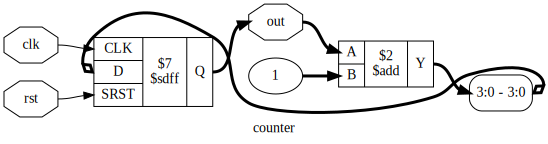

In [21]:
import graphviz
graphviz.Source.from_file('synth_design.dot')

### Synth gates

Synthesize gate netlist: map to built-in `XOR` and `AND` logic gates.

In [22]:
%%script miniconda-synth/bin/yosys -Q -T

read -sv counter.v
hierarchy -top counter

proc; opt
techmap; opt

opt_clean
show -format dot -prefix synth_gate
stat


yosys> 
yosys> 

1. Executing Verilog-2005 frontend: counter.v
Parsing SystemVerilog input from `counter.v' to AST representation.
Storing AST representation for module `$abstract\counter'.
Storing AST representation for module `$abstract\counter_tb'.
Successfully finished Verilog frontend.

yosys> 
2. Executing HIERARCHY pass (managing design hierarchy).

3. Executing AST frontend in derive mode using pre-parsed AST for module `\counter'.
Generating RTLIL representation for module `\counter'.

3.1. Analyzing design hierarchy..
Top module:  \counter

3.2. Analyzing design hierarchy..
Top module:  \counter
Removing unused module `$abstract\counter_tb'.
Removing unused module `$abstract\counter'.
Removed 2 unused modules.

yosys> 
yosys> 
4. Executing PROC pass (convert processes to netlists).

4.1. Executing PROC_CLEAN pass (remove empty switches from decision trees).
Cleaned up 0 empty switches.

4.2. Executing PROC_RMDEAD pass (remove dead branches from decision trees).
Marked 1 swit

In [44]:
%%writefile gate2andinv.v
module \$and (input A, B, output Y);
  assign Y = A & B;
endmodule

module \$not (input A, output Y);
  assign Y = ~A;
endmodule

// Simulating an XOR gate using AND, OR, NOT
module \$xor (input A, B, output Y);
  wire nA, nB, a1, a2;
  \$not na(A, nA);
  \$not nb(B, nB);
  \$and a1(A, nB, a1);
  \$and a2(B, nA, a2);
  \$or o1(a1, a2, Y);
endmodule

// Example of implementing a half-adder using AND and XOR
module \$half_adder(input A, B, output SUM, CARRY);
  \$xor sum_gate(A, B, SUM);
  \$and carry_gate(A, B, CARRY);
endmodule




Overwriting gate2andinv.v


In [46]:
# Run Yosys script
%%script miniconda-synth/bin/yosys -Q -T
  read -sv counter.v
  hierarchy -top counter

  proc; opt

  # Ensure the technology mapping file is properly specified and comprehensive
  techmap -map gate2andinv.v

  opt_clean
  show -format dot -prefix synth_gate
  stat



yosys> 

1. Executing Verilog-2005 frontend: counter.v
Parsing SystemVerilog input from `counter.v' to AST representation.
Storing AST representation for module `$abstract\counter'.
Storing AST representation for module `$abstract\counter_tb'.
Successfully finished Verilog frontend.

yosys> 
2. Executing HIERARCHY pass (managing design hierarchy).

3. Executing AST frontend in derive mode using pre-parsed AST for module `\counter'.
Generating RTLIL representation for module `\counter'.

3.1. Analyzing design hierarchy..
Top module:  \counter

3.2. Analyzing design hierarchy..
Top module:  \counter
Removing unused module `$abstract\counter_tb'.
Removing unused module `$abstract\counter'.
Removed 2 unused modules.

yosys> 
yosys> 
4. Executing PROC pass (convert processes to netlists).

4.1. Executing PROC_CLEAN pass (remove empty switches from decision trees).
Cleaned up 0 empty switches.

4.2. Executing PROC_RMDEAD pass (remove dead branches from decision trees).
Marked 1 switch rules

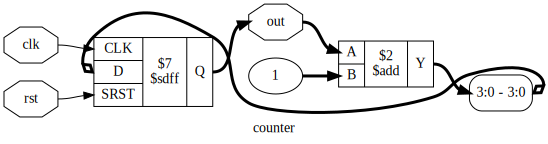

In [40]:
import graphviz
graphviz.Source.from_file('synth_gate.dot')

### Synth FPGA

Synthesize FPGA netlist: map to `IC40` `LUT` gates using a builtin synthesis script.

In [ ]:
%%script miniconda-synth/bin/yosys -Q -T

read -sv adder.v
hierarchy -top adder

synth_ice40

opt_clean
show -format dot -prefix synth_ice40


yosys> 
yosys> 

1. Executing Verilog-2005 frontend: adder.v
Parsing SystemVerilog input from `adder.v' to AST representation.
Storing AST representation for module `$abstract\adder'.
Successfully finished Verilog frontend.

yosys> 
2. Executing HIERARCHY pass (managing design hierarchy).

3. Executing AST frontend in derive mode using pre-parsed AST for module `\adder'.
Generating RTLIL representation for module `\adder'.

3.1. Analyzing design hierarchy..
Top module:  \adder

3.2. Analyzing design hierarchy..
Top module:  \adder
Removing unused module `$abstract\adder'.
Removed 1 unused modules.

yosys> 
yosys> 
4. Executing SYNTH_ICE40 pass.

4.1. Executing Verilog-2005 frontend: /content/miniconda-synth/bin/../share/yosys/ice40/cells_sim.v
Parsing Verilog input from `/content/miniconda-synth/bin/../share/yosys/ice40/cells_sim.v' to AST representation.
Generating RTLIL representation for module `\SB_IO'.
Generating RTLIL representation for module `\SB_GB_IO'.
Generating RTLIL repre

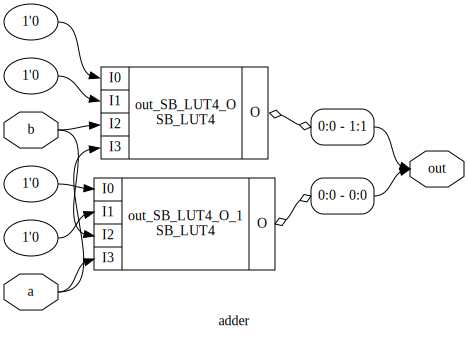

In [ ]:
import graphviz
graphviz.Source.from_file('synth_ice40.dot')

### Synth CMOS

Synthesize CMOS netlist: map to `NOR` and `NOT` gates using CMOS technology mapping from `yosys examples.

In [47]:
!curl --silent -L https://github.com/YosysHQ/yosys/archive/refs/tags/yosys-0.11.tar.gz | tar xvzf - yosys-yosys-0.11/examples/cmos --strip-components=2

yosys-yosys-0.11/examples/cmos/
yosys-yosys-0.11/examples/cmos/.gitignore
yosys-yosys-0.11/examples/cmos/README
yosys-yosys-0.11/examples/cmos/cmos_cells.lib
yosys-yosys-0.11/examples/cmos/cmos_cells.sp
yosys-yosys-0.11/examples/cmos/cmos_cells.v
yosys-yosys-0.11/examples/cmos/cmos_cells_digital.sp
yosys-yosys-0.11/examples/cmos/counter.v
yosys-yosys-0.11/examples/cmos/counter.ys
yosys-yosys-0.11/examples/cmos/counter_digital.ys
yosys-yosys-0.11/examples/cmos/counter_tb.gtkw
yosys-yosys-0.11/examples/cmos/counter_tb.v
yosys-yosys-0.11/examples/cmos/testbench.sh
yosys-yosys-0.11/examples/cmos/testbench.sp
yosys-yosys-0.11/examples/cmos/testbench_digital.sh
yosys-yosys-0.11/examples/cmos/testbench_digital.sp


In [49]:
%%script miniconda-synth/bin/yosys -Q -T

read -sv counter.v
hierarchy -top counter

read -sv -lib cmos/cmos_cells.v
synth
dfflibmap -liberty cmos/cmos_cells.lib
abc -liberty cmos/cmos_cells.lib

opt_clean
show -format dot -prefix synth_cmos
stat -liberty cmos/cmos_cells.lib


yosys> 
yosys> 

1. Executing Verilog-2005 frontend: counter.v
Parsing SystemVerilog input from `counter.v' to AST representation.
Storing AST representation for module `$abstract\counter'.
Storing AST representation for module `$abstract\counter_tb'.
Successfully finished Verilog frontend.

yosys> 
2. Executing HIERARCHY pass (managing design hierarchy).

3. Executing AST frontend in derive mode using pre-parsed AST for module `\counter'.
Generating RTLIL representation for module `\counter'.

3.1. Analyzing design hierarchy..
Top module:  \counter

3.2. Analyzing design hierarchy..
Top module:  \counter
Removing unused module `$abstract\counter_tb'.
Removing unused module `$abstract\counter'.
Removed 2 unused modules.

yosys> 
yosys> 
4. Executing Verilog-2005 frontend: cmos/cmos_cells.v
Parsing SystemVerilog input from `cmos/cmos_cells.v' to AST representation.
Storing AST representation for module `$abstract\BUF'.
Storing AST representation for module `$abstract\NOT'.
Storing AST 

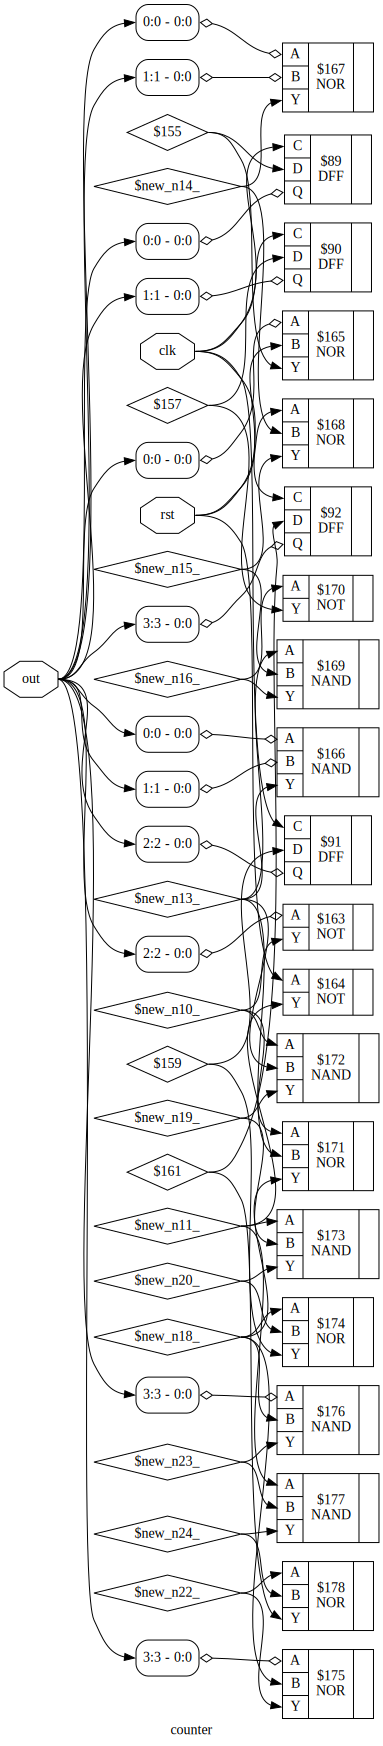

In [50]:
import graphviz
graphviz.Source.from_file('synth_cmos.dot')

### Synth 74xx

Synthesize 74xx netlist: map to `74AC08` a nd `74AC86` discrete gate ICs using community provided technology mapping.

In [52]:
!git clone https://github.com/Ravenslofty/74xx-liberty

Cloning into '74xx-liberty'...
remote: Enumerating objects: 238, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 238 (delta 59), reused 58 (delta 58), pack-reused 170
Receiving objects: 100% (238/238), 112.96 KiB | 3.64 MiB/s, done.
Resolving deltas: 100% (128/128), done.


In [76]:
%%writefile adder.v

module adder(
  input wire a,
  input wire b,
  output wire [1:0] out
);
  assign out = a + b;
endmodule

Writing adder.v


In [83]:
%%script miniconda-synth/bin/yosys -Q -T

read -sv adder.v
hierarchy -top adder

synth -flatten -top adder
abc -g AND
write_aiger -ascii adder.aag


yosys> 
yosys> 

1. Executing Verilog-2005 frontend: adder.v
Parsing SystemVerilog input from `adder.v' to AST representation.
Storing AST representation for module `$abstract\adder'.
Successfully finished Verilog frontend.

yosys> 
2. Executing HIERARCHY pass (managing design hierarchy).

3. Executing AST frontend in derive mode using pre-parsed AST for module `\adder'.
Generating RTLIL representation for module `\adder'.

3.1. Analyzing design hierarchy..
Top module:  \adder

3.2. Analyzing design hierarchy..
Top module:  \adder
Removing unused module `$abstract\adder'.
Removed 1 unused modules.

yosys> 
yosys> 
4. Executing SYNTH pass.

4.1. Executing HIERARCHY pass (managing design hierarchy).

4.1.1. Analyzing design hierarchy..
Top module:  \adder

4.1.2. Analyzing design hierarchy..
Top module:  \adder
Removed 0 unused modules.

4.2. Executing PROC pass (convert processes to netlists).

4.2.1. Executing PROC_CLEAN pass (remove empty switches from decision trees).
Cleaned up 0 e

In [72]:
%%script miniconda-synth/bin/yosys -Q -T

read -sv counter.v
hierarchy -top counter

read -sv -lib 74xx-liberty/74_models.v
synth
abc -liberty 74xx-liberty/74ac.lib
dfflibmap -liberty 74xx-liberty/74ac.lib

write_verilog -noattr -renameprefix syn_ synth_netlist.v


opt_clean
show -format dot -prefix synth_74
stat -liberty 74xx-liberty/74ac.lib


yosys> 
yosys> 

1. Executing Verilog-2005 frontend: counter.v
Parsing SystemVerilog input from `counter.v' to AST representation.
Storing AST representation for module `$abstract\counter'.
Storing AST representation for module `$abstract\counter_tb'.
Successfully finished Verilog frontend.

yosys> 
2. Executing HIERARCHY pass (managing design hierarchy).

3. Executing AST frontend in derive mode using pre-parsed AST for module `\counter'.
Generating RTLIL representation for module `\counter'.

3.1. Analyzing design hierarchy..
Top module:  \counter

3.2. Analyzing design hierarchy..
Top module:  \counter
Removing unused module `$abstract\counter_tb'.
Removing unused module `$abstract\counter'.
Removed 2 unused modules.

yosys> 
yosys> 
4. Executing Verilog-2005 frontend: 74xx-liberty/74_models.v
Parsing SystemVerilog input from `74xx-liberty/74_models.v' to AST representation.
Storing AST representation for module `$abstract\74HC85_1x1CMP4'.
Storing AST representation for module `$ab

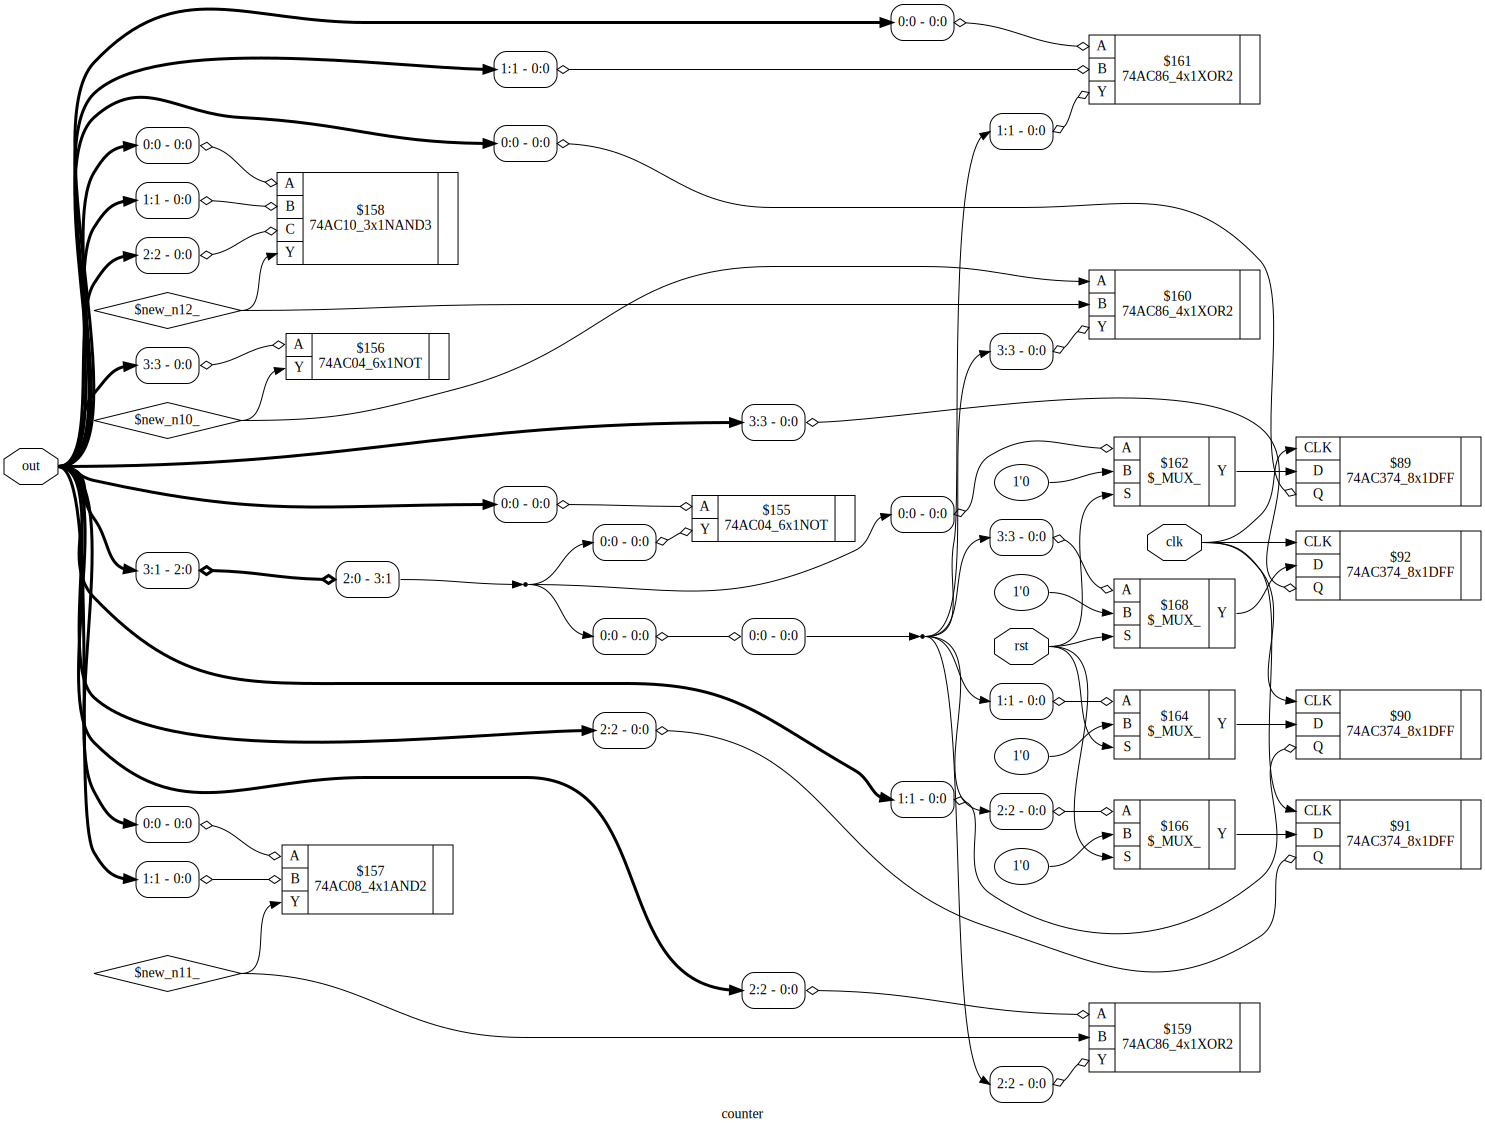

In [54]:
import graphviz
graphviz.Source.from_file('synth_74.dot')